# Saliency

In [1]:
default_wrkspc = dir()

In [2]:
%%bash
echo "Current branch"
git branch

Current branch
  explore_appr_retr
  gh-pages
* master
  refactor_appr_retr


In [3]:
%load_ext watermark
%watermark

2020-11-02T11:41:31-05:00

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-1093-oem
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit


In [7]:
from src.preprocess.dataset import *
import tensorflow as tf
import os
import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
## Inputs
# Data path
data = '../../data/processed/00a-ROI316_withShiftedSegments.pkl'
# Model path
model = tf.keras.models.load_model('../../models/01-ROI316_last_segment/CustomGRU.h5')

In [6]:
## Load inputs
dataset = Dataset(data)
dataset.load()
dataset_df = organize_dataset(selective_segments(dataset.data,5))
dataset.train_test_split_sid()

X_train, y_train = query_dataset(dataset_df,dataset.train_idx)
X_test, y_test = query_dataset(dataset_df,dataset.test_idx)
print('\nTesting on %i/%i participants' %(len(dataset.test_idx),len(dataset.sid())))


Testing on 19/61 participants


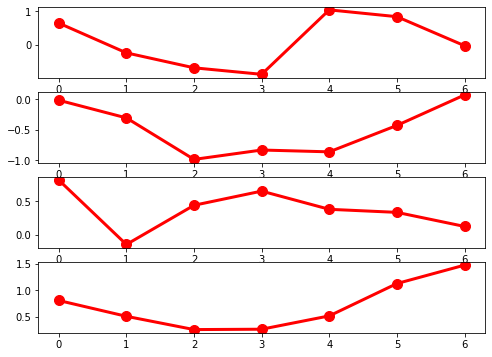

In [47]:
fig, axes = plt.subplots(nrows=4,figsize=(8,6))
for ii, ax in enumerate(axes):
    _=axes[ii].plot(X_train[2,:,ii],marker='o',color='r',linewidth=3, markersize=10)

In [18]:
import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain, plot_epi, plot_matrix
from nilearn import plotting

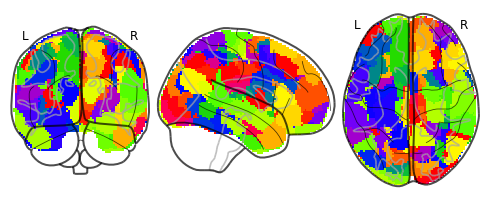

In [40]:
plot_glass_brain('../../data/processed/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz',cmap='prism')


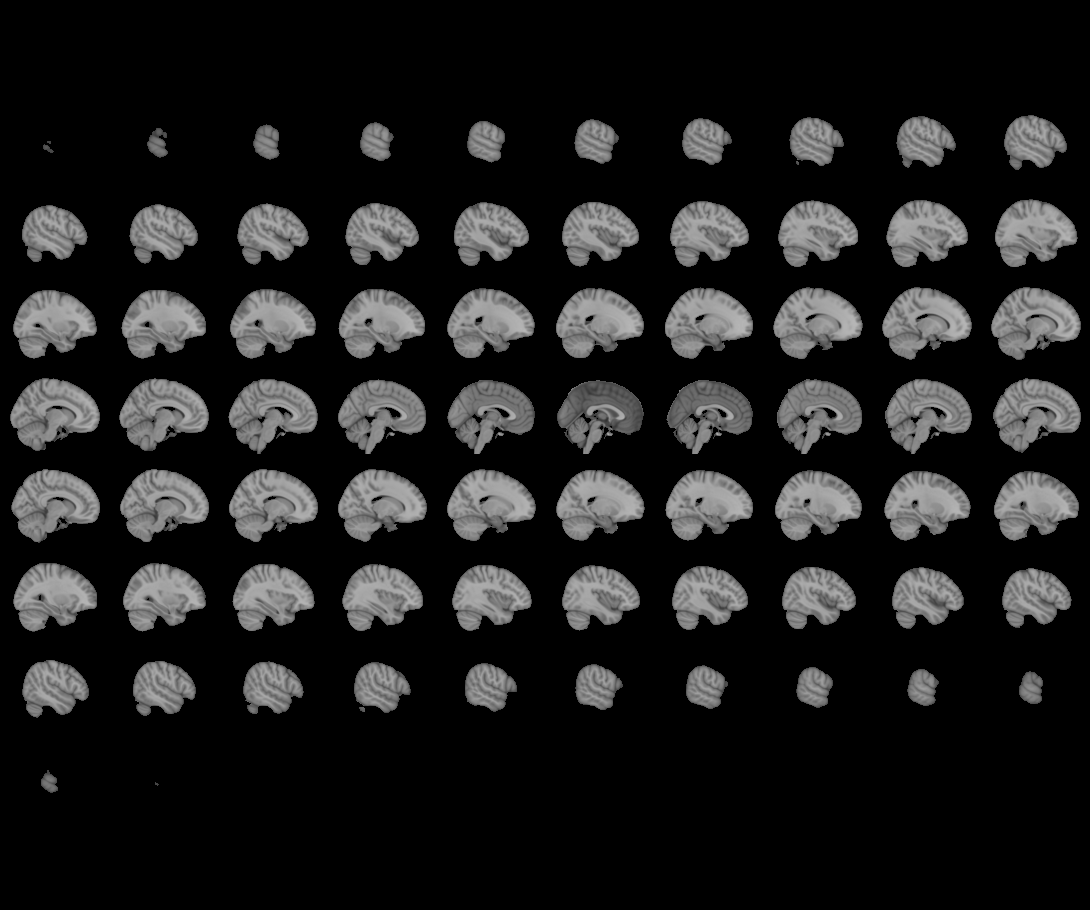
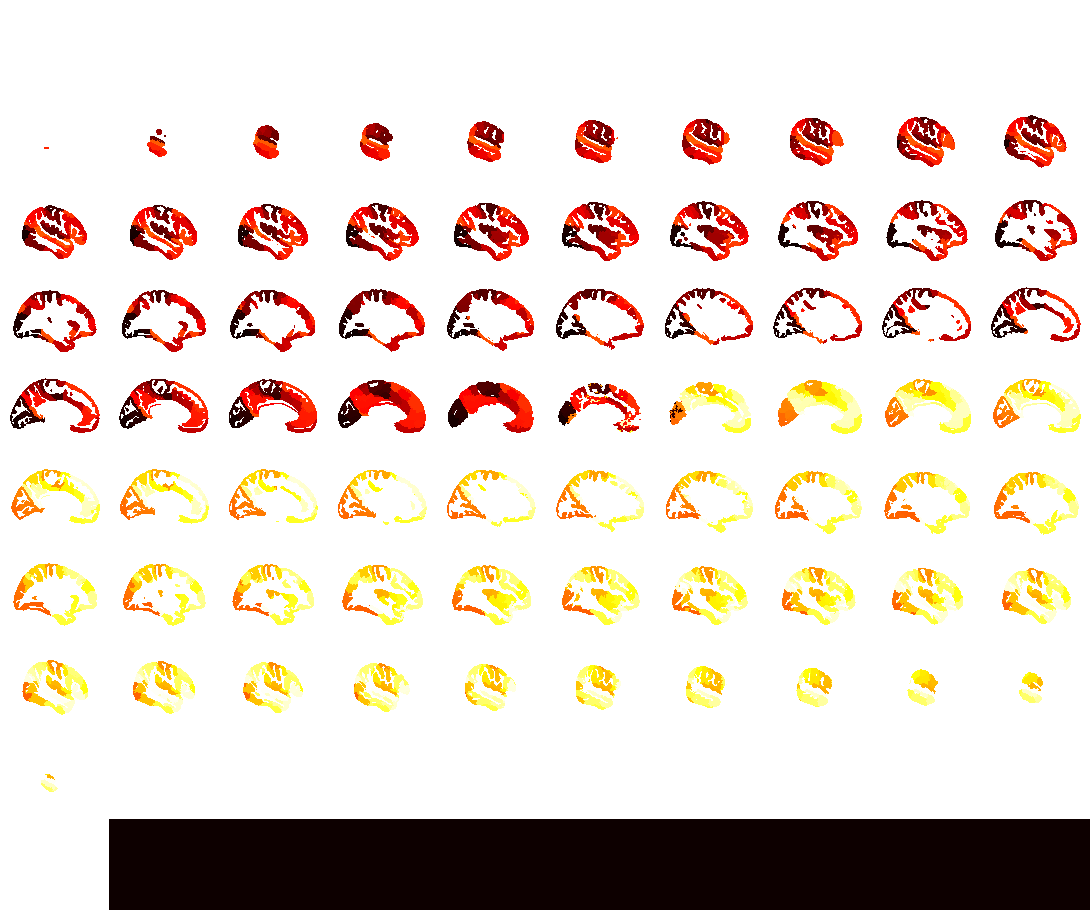

In [35]:
plotting.view_img('../../data/processed/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz',
                  black_bgboolean=True)

In [7]:
# Compute observed accuracy
obs_loss, obs_acc = model.evaluate(X_test,y_test)

52/52 [==============================] - 0s 9ms/step - loss: 0.4465 - acc: 0.8319


## Vanilla Saliency

In [8]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# The `output` variable refer to the output of the model
def loss(output):
    print(output.shape)
    return output

In [51]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

saliency = Saliency(model, model_modifier=model_modifier, clone=False) # model_modifier=model_modifier, 
saliency_map = saliency(loss,X_test, keepdims=True)
saliency_map = normalize(saliency_map)

print('Saliency Map shape:', saliency_map.shape)

(1648, 7, 1)
Saliency Map shape: (1648, 7, 316)
CPU times: user 140 ms, sys: 8.92 ms, total: 149 ms
Wall time: 147 ms


In [52]:
mean_saliency_map = saliency_map.numpy().mean(axis=0)
mean_saliency_map.shape

(7, 316)

## Rendering Saliency to Brain Template

In [53]:
import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain, plot_epi, plot_matrix
from nilearn import plotting

In [54]:
cortical_img = nil.image.load_img("../../data/processed/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz")
subcortical_img = nil.image.load_img("../../data/processed/masks/00b-subcortical_ROIs.nii.gz")

In [55]:
vols = []
for tp in range(mean_saliency_map.shape[0]):
    saliency_brainmap = np.zeros_like(cortical_img.get_fdata())
    for i in range(316):
        if i < 300:
            saliency_brainmap[cortical_img.get_fdata() == i+1] = mean_saliency_map[tp,i]
        else:
            j = i - 300
            saliency_brainmap[subcortical_img.get_fdata() == j+1] = mean_saliency_map[tp,i]
        
    vols.append(nil.image.new_img_like(cortical_img,saliency_brainmap))
    
saliency_brainmap_img = nil.image.concat_imgs(vols,ensure_ndim=4)
saliency_brainmap_img.to_filename('../../results/01-ROI316_last_segment/saliency_bm_ROI316.nii.gz')

In [56]:
vols[0].get_fdata().max()

0.9818972614426804

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



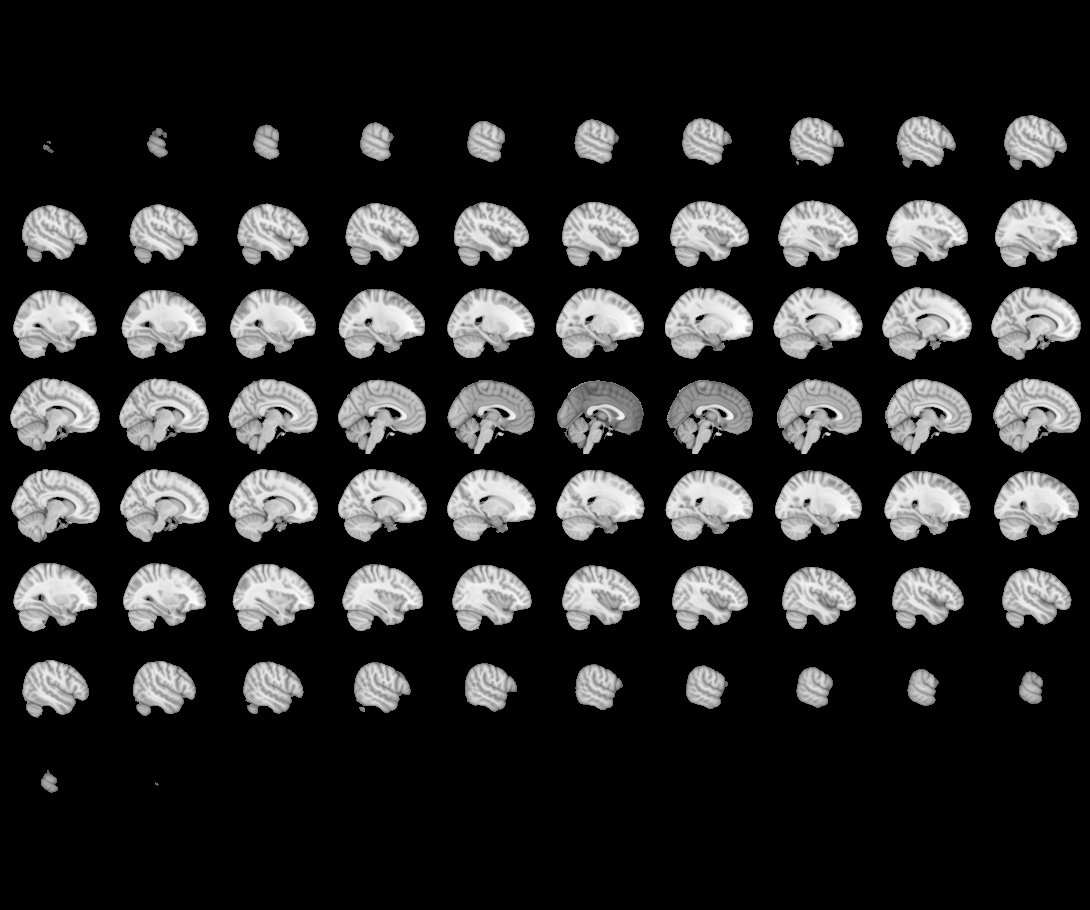
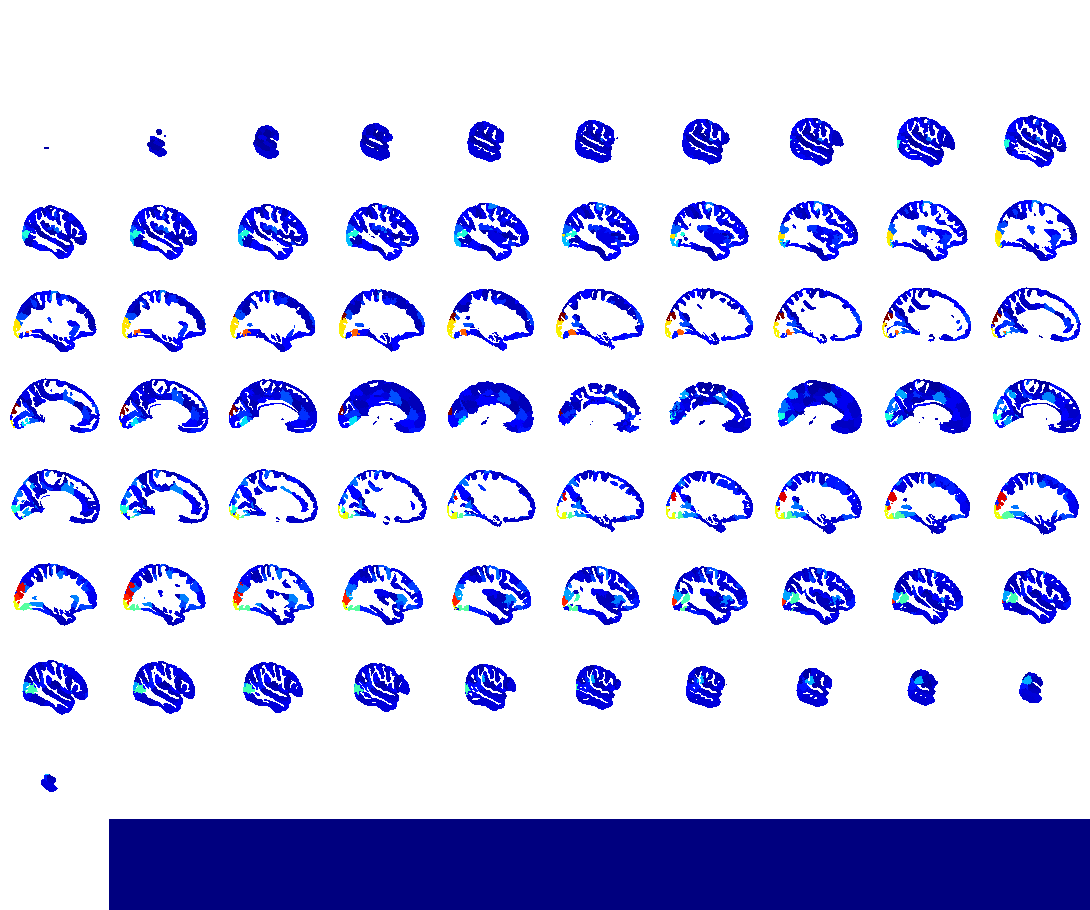

In [57]:
plotting.view_img(vols[0],dim=0, vmax=vols[0].get_fdata().max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR1',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



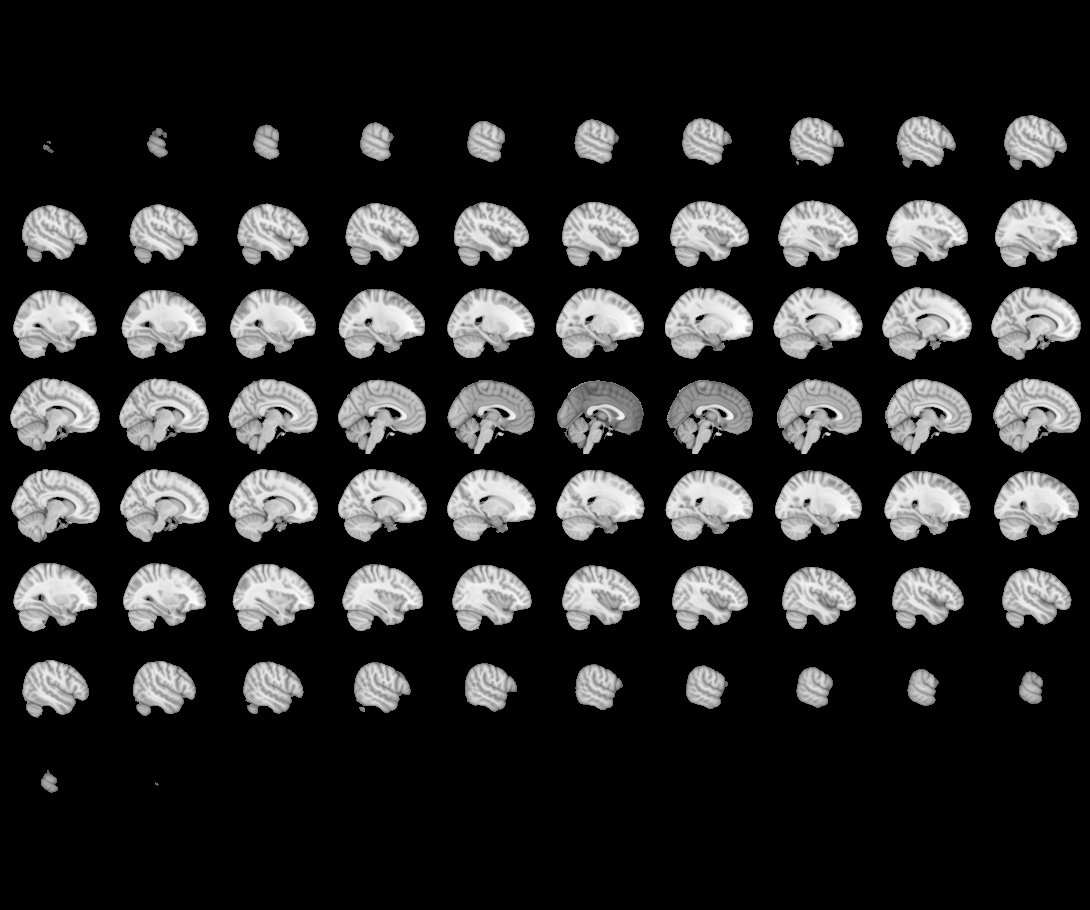
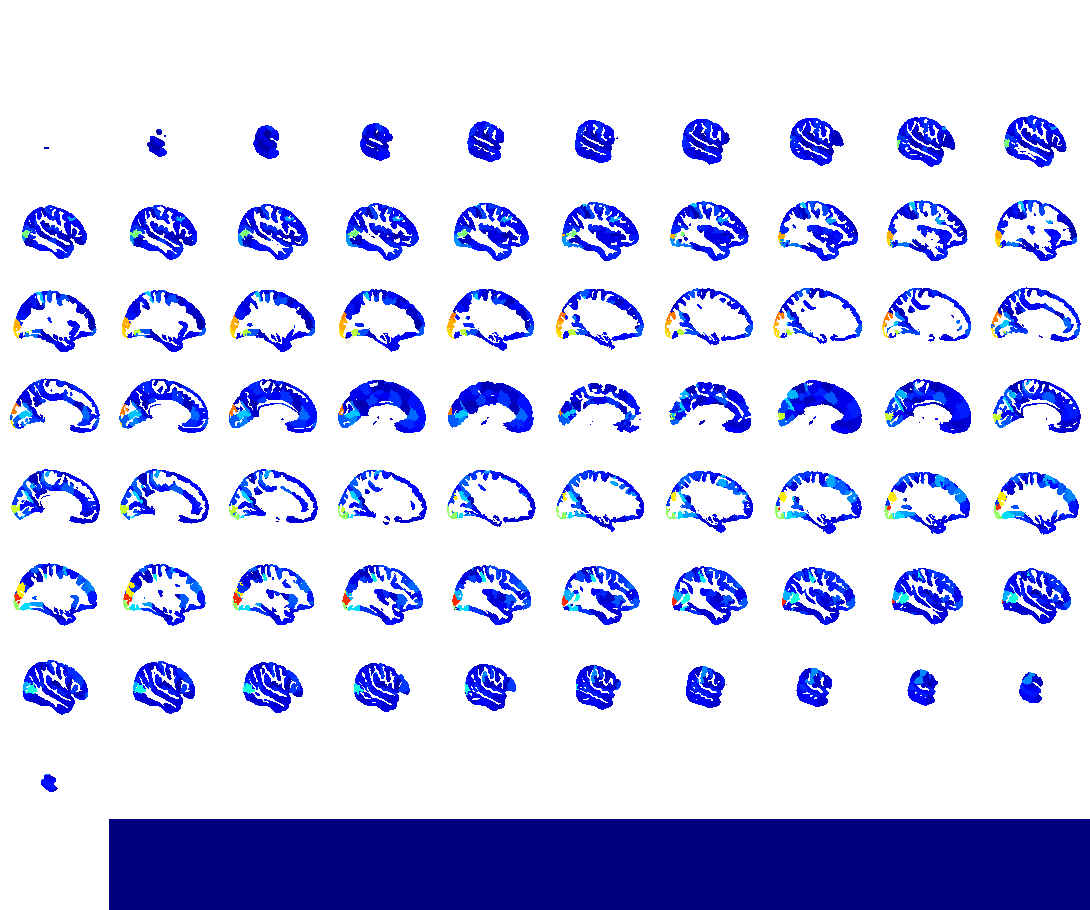

In [43]:
plotting.view_img(vols[1],dim=0, vmax=0.25,
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR2',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



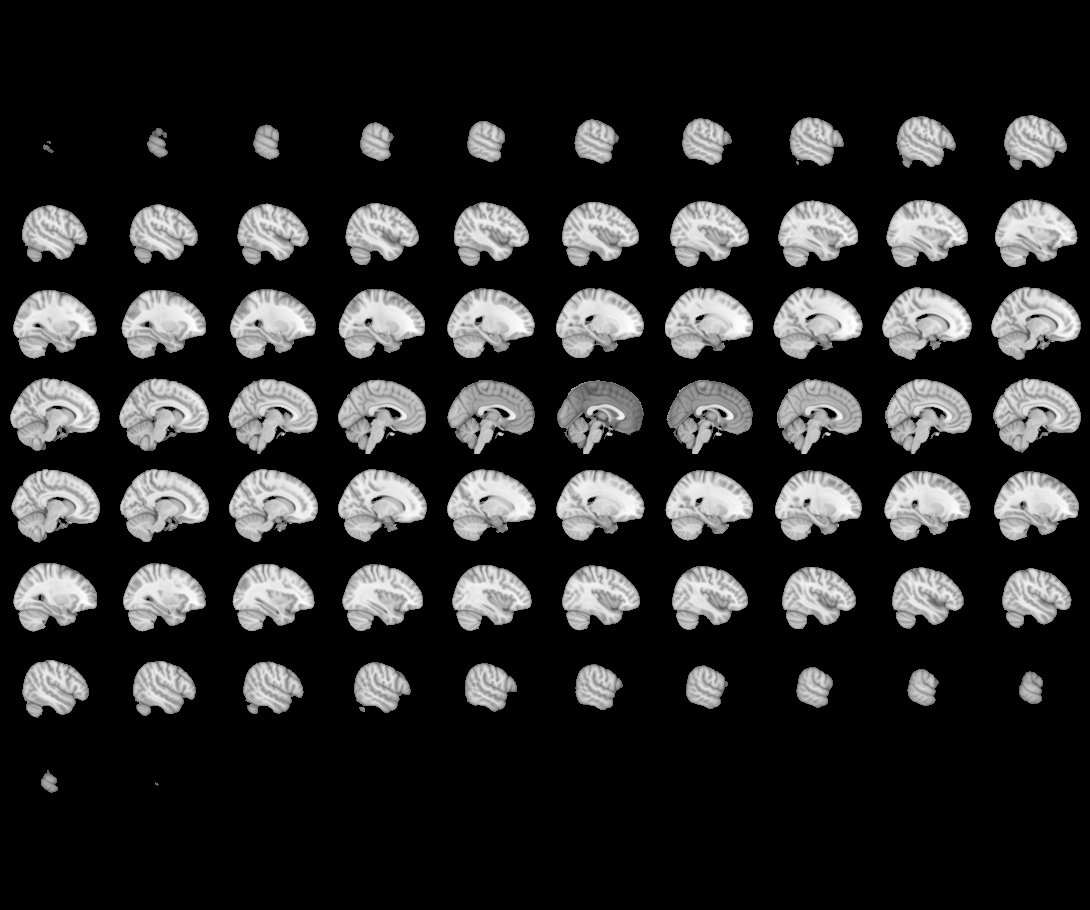
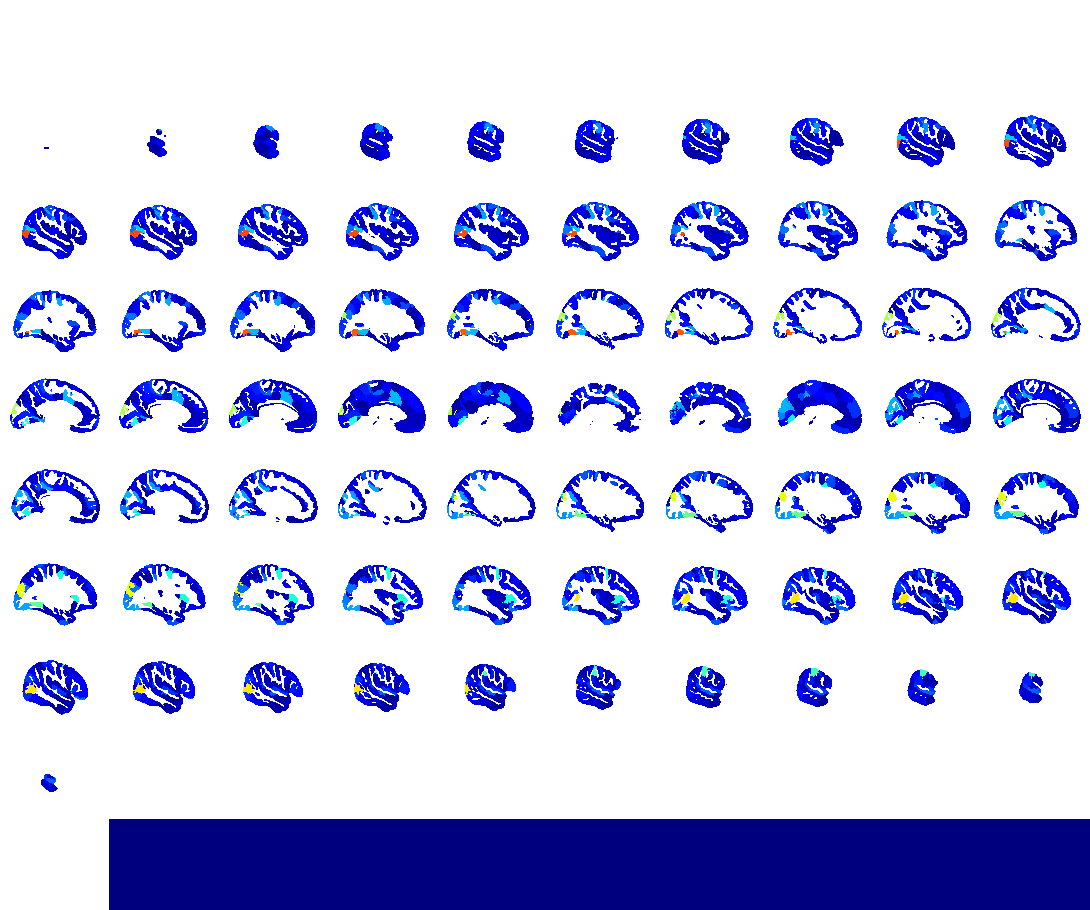

In [44]:
plotting.view_img(vols[2],dim=0, vmax=0.25,
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR3',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



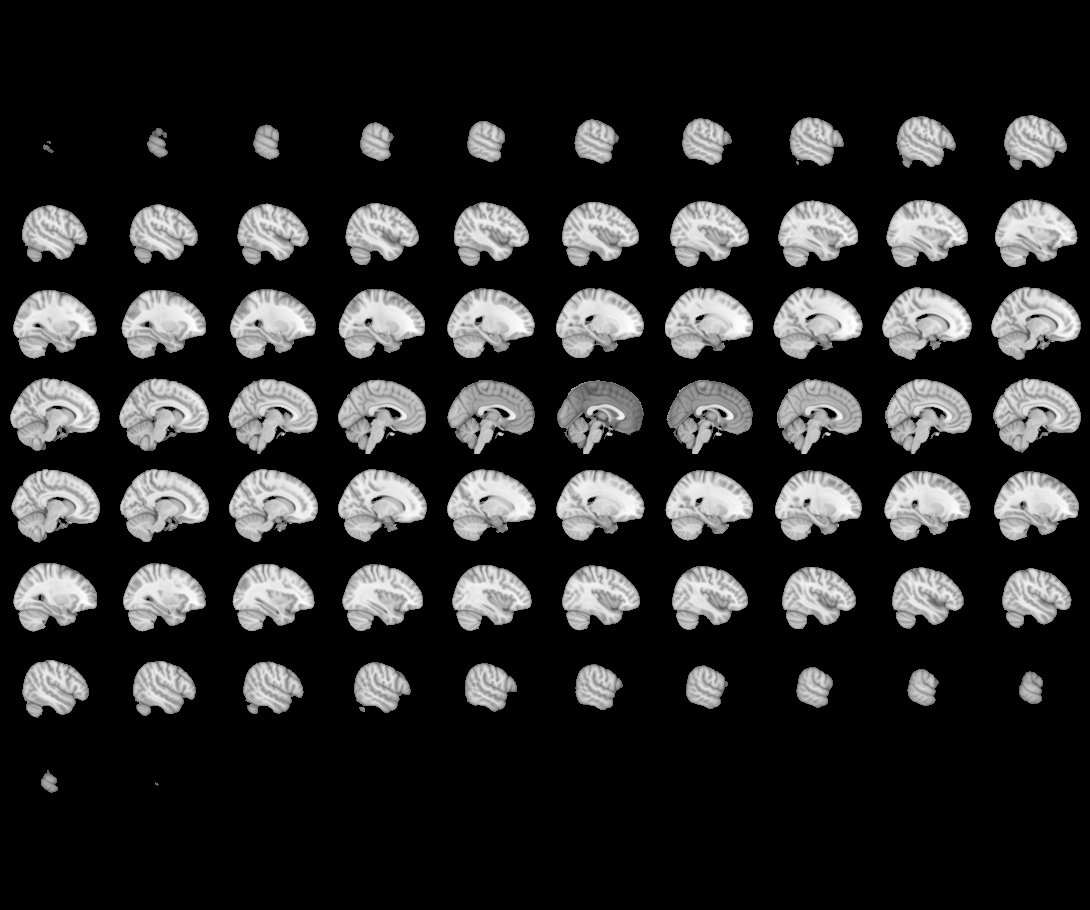
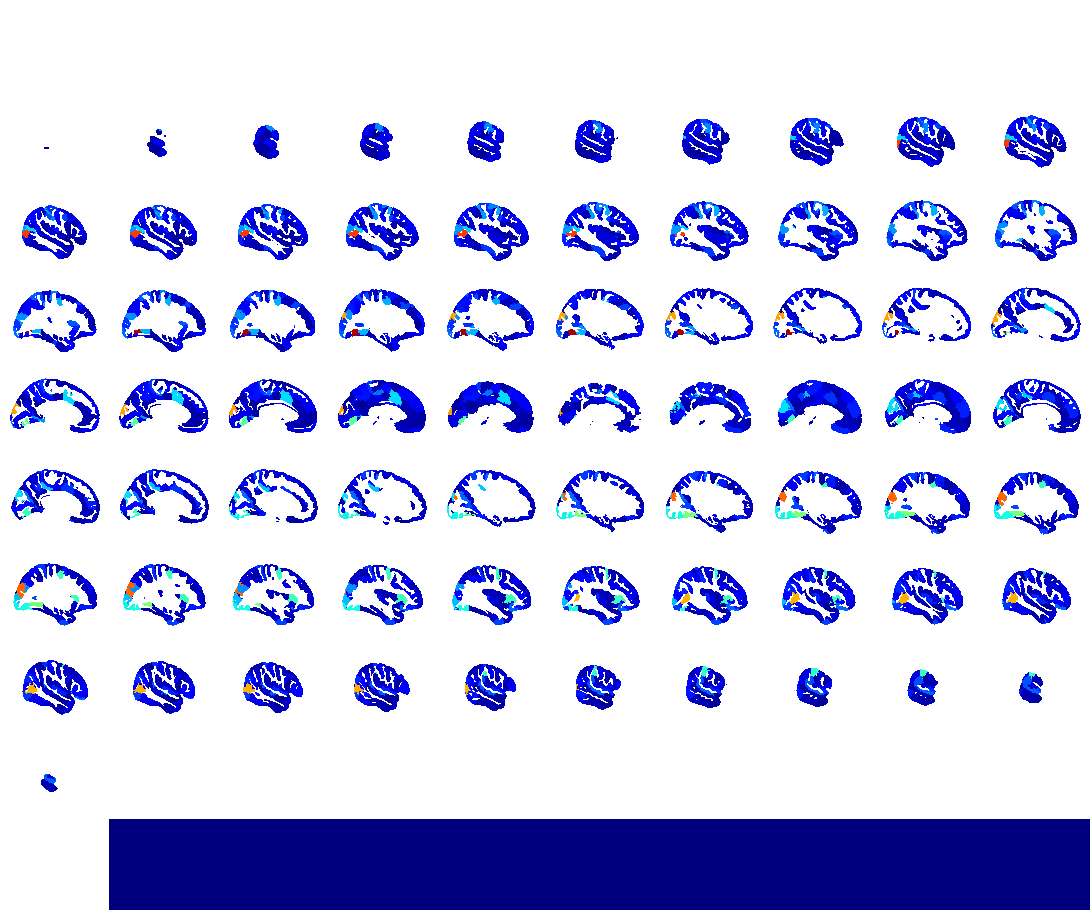

In [45]:
plotting.view_img(vols[3],dim=0, vmax=0.25,
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR4',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



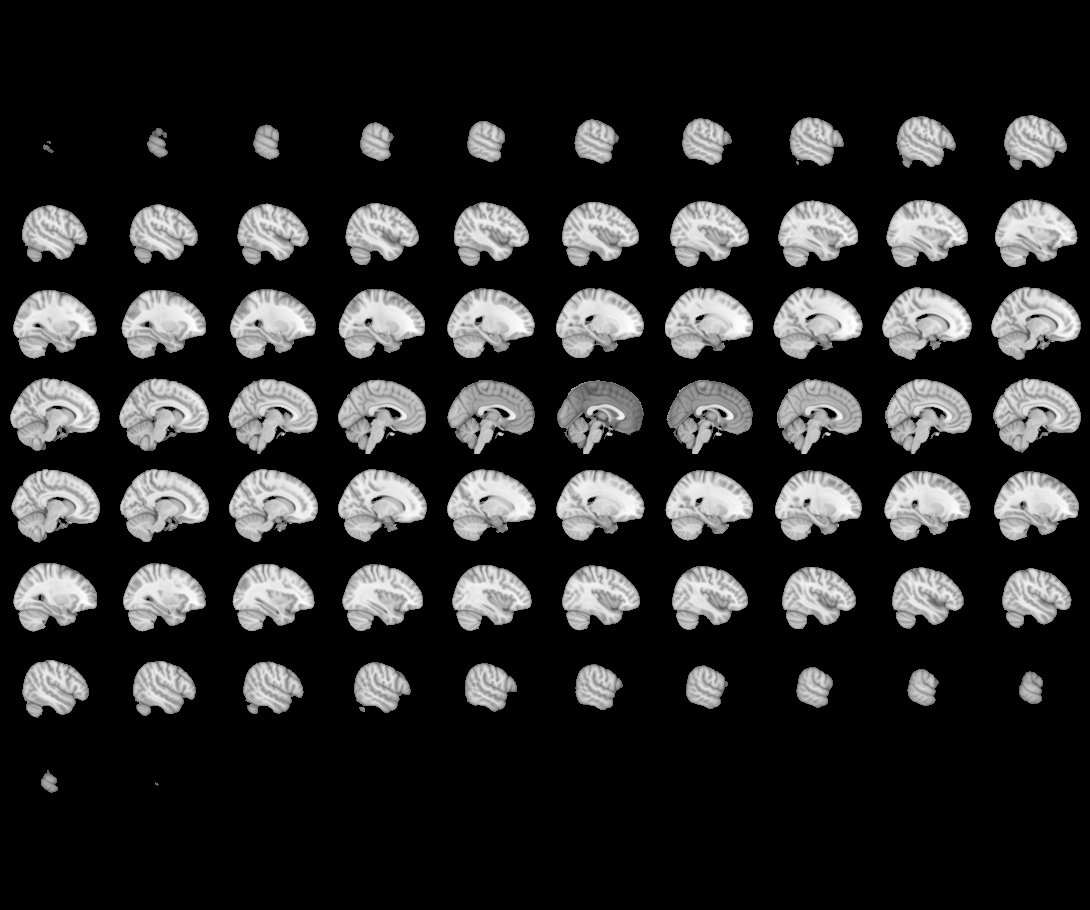
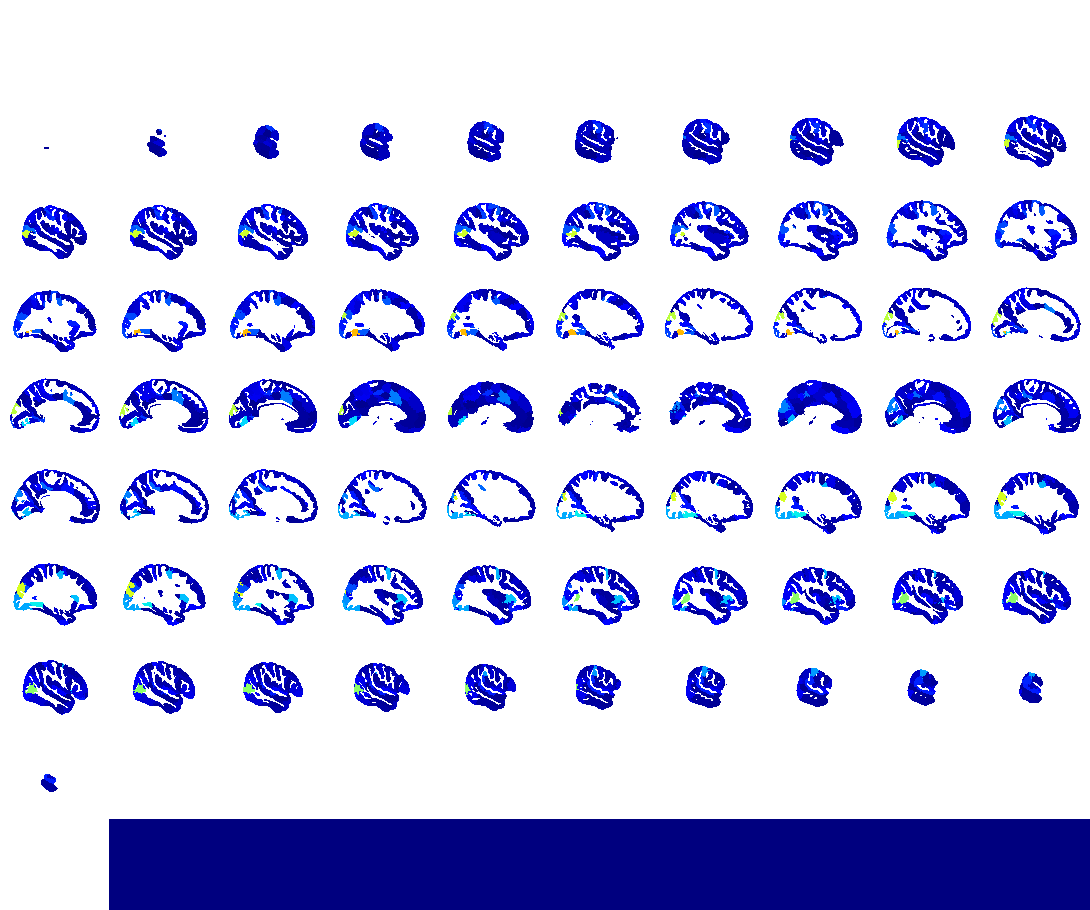

In [46]:
plotting.view_img(vols[4],dim=0, vmax=0.25,
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR5',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



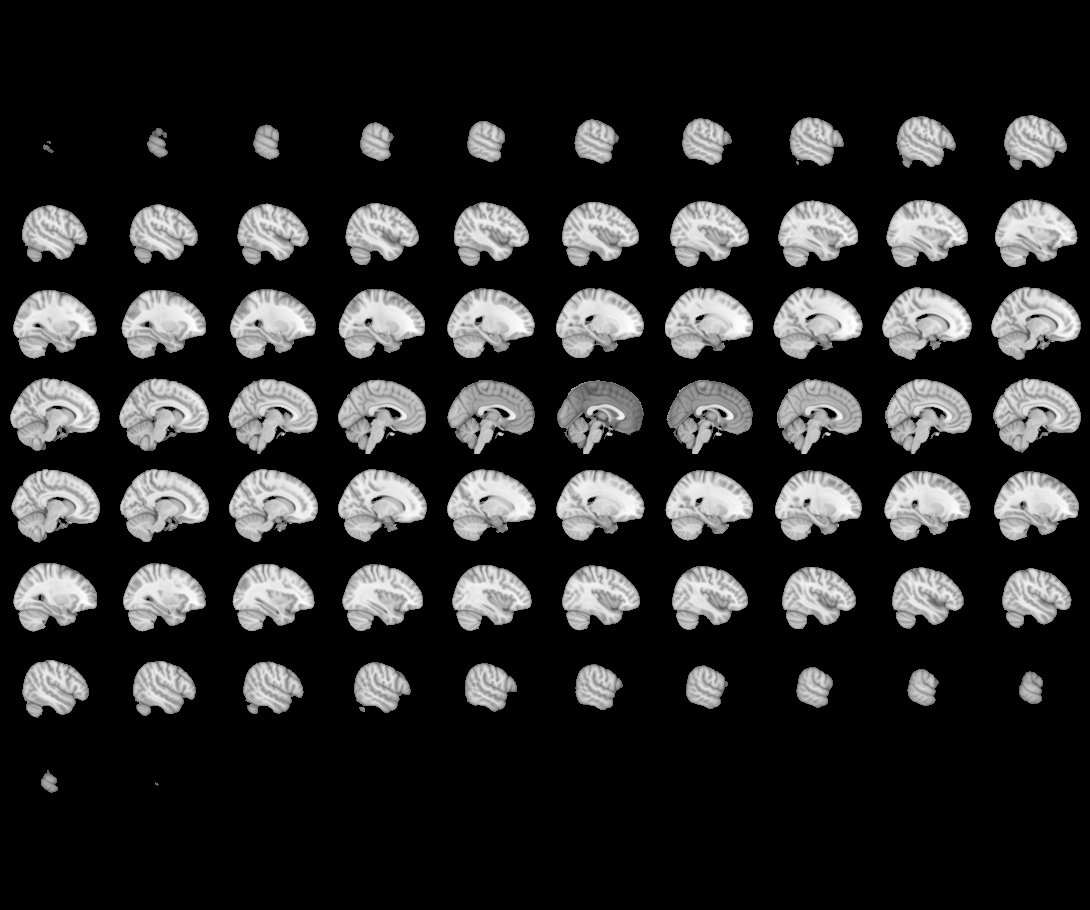
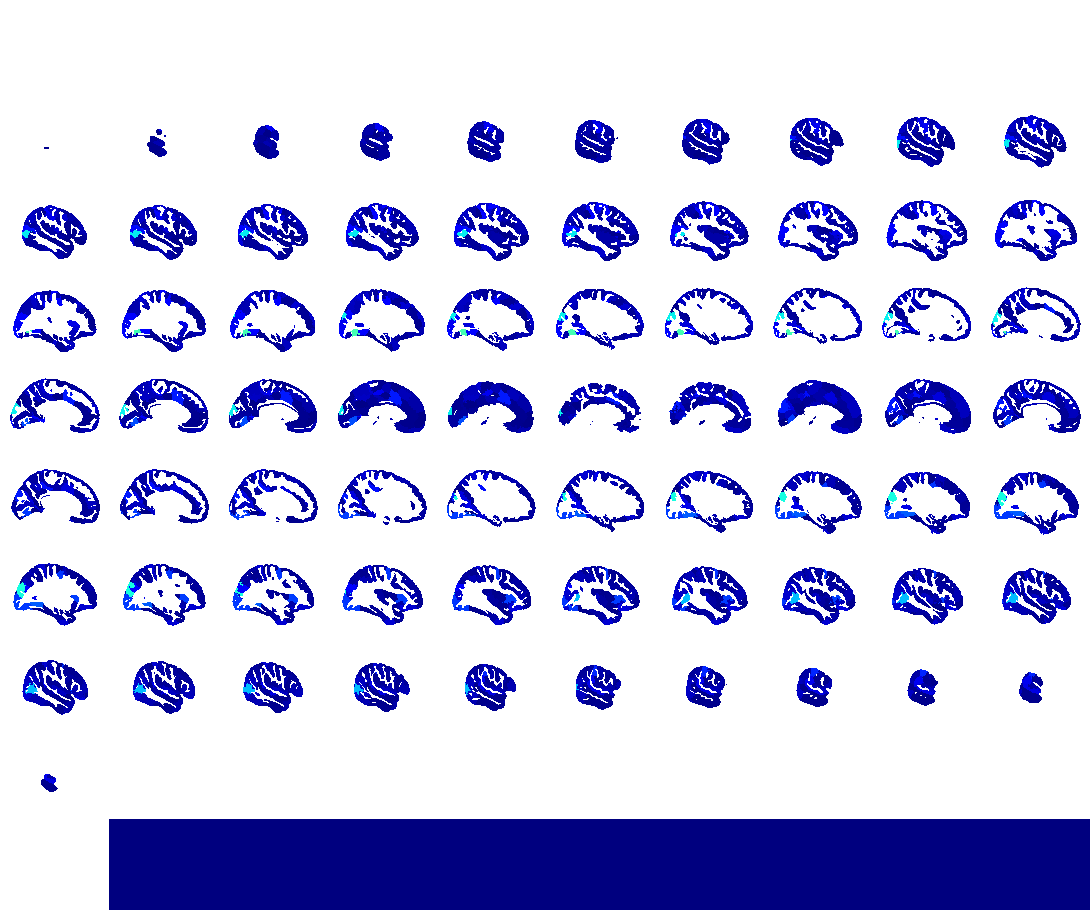

In [47]:
plotting.view_img(vols[5],dim=0, vmax=0.25,
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR6',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



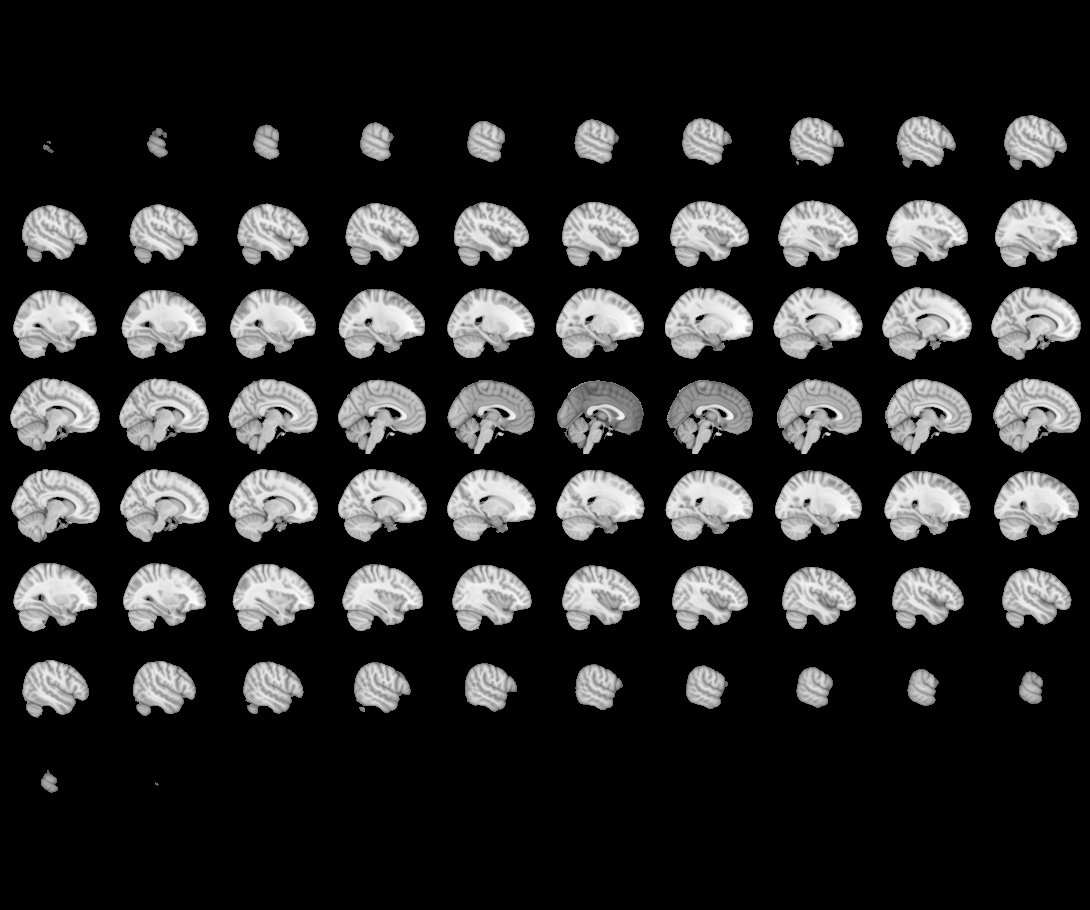
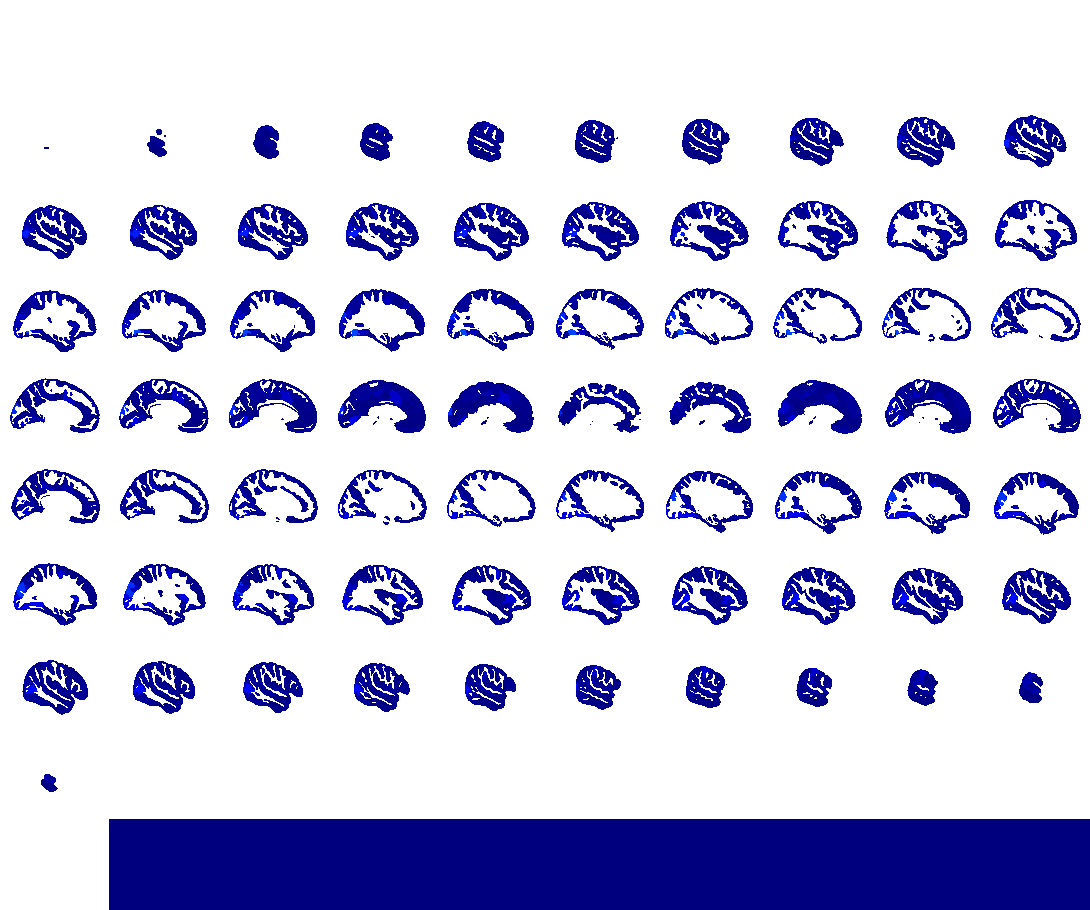

In [48]:
plotting.view_img(vols[6],dim=0, vmax=0.25,
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR7',cmap='jet')

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

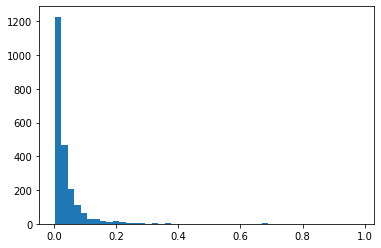

In [31]:
_=plt.hist(mean_saliency_map.flatten(),bins=int(np.sqrt(mean_saliency_map.flatten().shape)))

In [42]:
np.sort(mean_saliency_map.flatten())[::-1][:20]

array([0.98218243, 0.87078714, 0.8522086 , 0.75900239, 0.68281268,
       0.6803641 , 0.60896407, 0.45395026, 0.4232951 , 0.37061208,
       0.36597709, 0.32898802, 0.32837788, 0.30677157, 0.27909886,
       0.27667076, 0.25786277, 0.25640649, 0.25374069, 0.24035995])

In [59]:
[np.max(vol.get_fdata()) for vol in vols ]

[0.9818972614426804,
 0.20907245519824727,
 0.14707426532370602,
 0.17370769379464124,
 0.13650695035718607,
 0.09225626610711639,
 0.044995900588652826]